<a href="https://colab.research.google.com/github/stevegbrooks/big-portfolio-learner/blob/big-data/big_portfolio_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Final Project

## Big Portfolio Learner

### Team members: Steven Brooks & Chenlia Xu

In [2]:
import random
import numpy as np 
import json
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os

In [3]:
## If statsmodels not the latest version uncomment the following:
#!pip install statsmodels --upgrade
## If boto3 not already installed uncomment the following:
#!pip3 install boto3

In [4]:
import boto3
from botocore import UNSIGNED

from botocore.config import Config

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
s3.Bucket('cis545project').download_file('data/stock_data.zip', 'stock_data.zip')
s3.Bucket('cis545project').download_file('data/technical_data.zip', 'technical_data.zip')

In [5]:
%%capture

in_dir = "stock_data"
if not os.path.exists(in_dir):
  os.makedirs(in_dir)
!unzip /content/stock_data.zip -d /content/$in_dir
!rm -f $in_dir/.gitempty

tech_dir = "technical_data"
if not os.path.exists(tech_dir):
  os.makedirs(tech_dir)
!unzip /content/technical_data.zip -d /content/$tech_dir
!rm -f $tech_dir/.gitempty

# Setup Spark Session

In [6]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install imageio --user
!pip install folium --user

!apt update
!apt install gcc python-dev libkrb5-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.16-2ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 79 not upgraded.
--2021-12-18 15:19:18--  https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving www-us.apache.org (www-us.apache.org)... failed: Name or service not known.
wget: unable to resolve host address ‘www-us.apache.org’
tar: spark-2.4.5-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exc

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.getOrCreate()

KeyboardInterrupt: ignored

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

# Section 1: Exploratory Data Analysis

The schema of the stock price data is as below:

In [ ]:
stock_data_files = os.listdir(in_dir)
# head of a random file
pd.read_csv(os.path.join(in_dir, stock_data_files[random.randrange(len(stock_data_files))])).head(5)

We will load the data into the Spark context here.

In [ ]:
stock_data_sdf = spark.read.load(
    'stock_data/*.csv', 
    format = 'csv', 
    header = 'true', 
    inferSchema = 'true', 
    sep = ','
)

stock_data_sdf.printSchema()

## Step 1: Inspect the data

First look at the number of rows of data across within each year for each stock.  

In [ ]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import year, month, dayofmonth

# Adding "year" and "month" to the dataset
stock_data_sdf = stock_data_sdf.withColumn("timestamp_as_dt", to_timestamp(stock_data_sdf.timestamp, 'yyyy-MM-dd'))
stock_data_sdf = stock_data_sdf.withColumn("year", year('timestamp_as_dt'))
stock_data_sdf = stock_data_sdf.withColumn("month", month('timestamp_as_dt'))
stock_data_sdf.printSchema()

#### We'll just look at the data from the years we are interested in: 2002 to 2019, inclusive.

In [ ]:
stock_data_sdf = stock_data_sdf.filter("year >= 2002 AND year <= 2019")

Here we calculate how many rows of data per year there are for each stock. Each row corresponds to a trading day.

We'll only take stocks that have data in each year between 2002 and 2019, inclusive.

In [ ]:
count_by_symbol_year_sdf = stock_data_sdf.groupBy(["symbol", "year"]).count()
count_years_by_symbol_sdf = count_by_symbol_year_sdf.groupBy(["symbol"]).count()

stocks_with_all_analysis_yrs_sdf = count_years_by_symbol_sdf.filter("count == 18") #18 years of data from 2002 and 2019

print("There are", stocks_with_all_analysis_yrs_sdf.count(), "stocks with data in each year from 2002 and 2019")

Now we move into SQL to limit the dataset to just these stocks that have full data in our analysis time range.

But first, lets visualize the number of rows per year for this set of stocks.

In [ ]:
stock_data_sdf.createOrReplaceTempView("stock_data")
count_by_symbol_year_sdf.createOrReplaceTempView("count_by_symbol_year")
stocks_with_all_analysis_yrs_sdf.createOrReplaceTempView("stocks_with_all_analysis_yrs")

count_by_symbol_year_filtered = spark.sql(
    """
    SELECT L.symbol, R.year, R.count
    FROM stocks_with_all_analysis_yrs L JOIN count_by_symbol_year R
    ON L.symbol = R.symbol
    """
).toPandas()

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 8

_ = sns.lineplot(
    x = "year", y = "count", 
    hue = "symbol", palette = "pastel", 
    legend = False, data = count_by_symbol_year_filtered
)

Now we will filter out just these stocks of interest from the main dataset.

In [ ]:
spark.sql(
    """
    SELECT *
    FROM stock_data
    WHERE symbol IN (SELECT symbol FROM stocks_with_all_analysis_yrs)
    """
).createOrReplaceTempView("stock_data_2002_2019")

And confirm the number here matches the above.

In [ ]:
spark.sql(
    """
    SELECT count(distinct(symbol))
    FROM stock_data_2002_2019
    """
).show()

Finally, clean out some stocks that have outlier prices, like "DCTH"

In [ ]:
import pyspark.sql.functions as F

stock_data_2002_2019_sdf = spark.sql("SELECT * FROM stock_data_2002_2019")

highest_closers_sdf = stock_data_2002_2019_sdf.groupBy('symbol').agg(F.max('adjusted_close').alias('max_close')).sort("max_close", ascending = False).limit(10)

highest_closers_sdf.show()

In [ ]:
stocks_to_remove = ['DCTH', 'BRK-A', 'AIKI']

stock_data_2002_2019_sdf = stock_data_2002_2019_sdf.filter(stock_data_2002_2019_sdf.symbol.isin(stocks_to_remove) == False)

from pyspark.sql.functions import countDistinct

stock_data_2002_2019_sdf.select(countDistinct("symbol")).show()

## Step 2: Visualize the time series data of adjusted closing price per day over this span.

In [1]:
_ = sns.lineplot(
    x = "timestamp_as_dt", y = "monthly_adjusted_close", 
    hue = "symbol", palette = "pastel", legend = False, 
    data = stock_data_2002_2019_sdf.groupBy(['year', 'month']).agg(F.sum('adjusted_close').alias('monthly_adjusted_close')).toPandas()
)

NameError: ignored

This plot clearly shows us that stock data over time is non-stationary. At the very least, the mean increases with time, but also the variance of the series appears time depenedent. However, the covariance *appears* to be constant with time.

#### Check if there is any seasonality trends by month

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


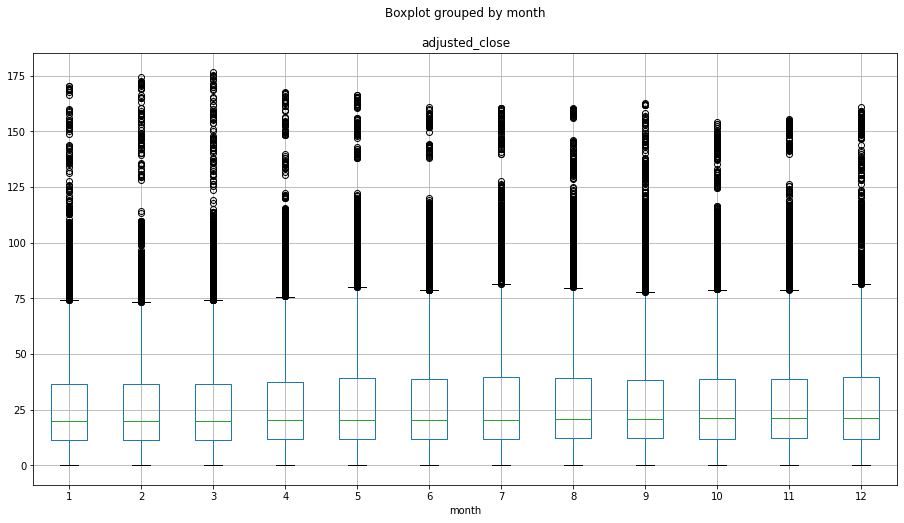

In [ ]:
sns.boxplot(x = 'adjusted_close', y = 'month', orient = 'h', palette = 'pastel', data = combined_data)

Looks like there are no seasonal trends.

# Section 2: Split the dataset

Our approach will be to create a training and validation set from 80% of the data, and hold 20% back as a test set for final evaluation of the model.

In [ ]:
%%spark

train = combined_data



# Section 3: Develop a naîve time series model to form a baseline.

This model will only look at the daily adjusted close price data and time.

Before we run the model, we'll have to stationarize our time series data.

We will use differencing and a log transform to take out the trends and stabilize the variance in the data (i.e., make it stationary).

In [ ]:
combined_data = combined_data.sort_values(by = ['symbol', 'timestamp_as_dt'])

combined_data['adjusted_close_log'] = np.log(combined_data['adjusted_close'])

combined_data['adjusted_close_log_diff'] = combined_data.groupby('symbol')['adjusted_close_log'].diff()

combined_data.reset_index(inplace = True)
combined_data.dropna(inplace = True)

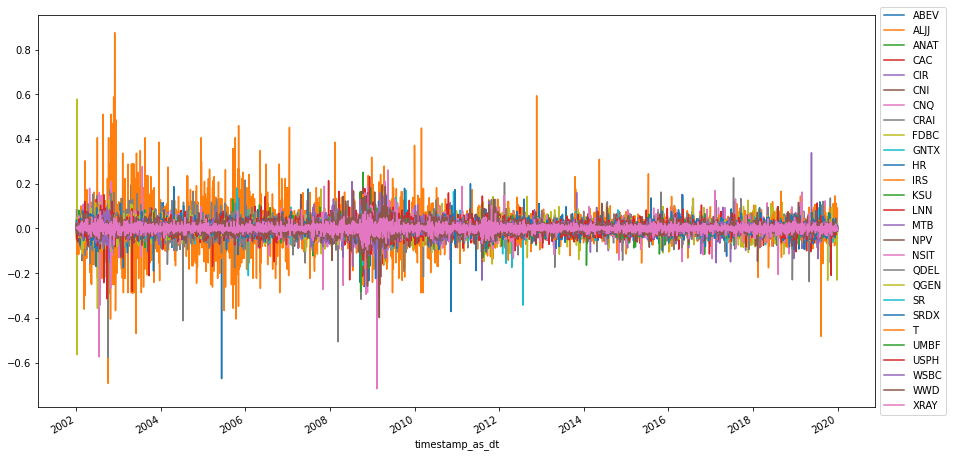

In [ ]:
fig, ax = plt.subplots()

for key, data in combined_data.groupby('symbol'):
  data.plot(x='timestamp_as_dt', y='adjusted_close_log_diff', ax=ax, label=key)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We will now look at the Autocorrelation plots to see which parameters we need to use in our time series model.

Stock data is typically an Autoregressive time series with lag of 1, but we will use the ACF and PACF plots to check what the optimal lag parameter is.

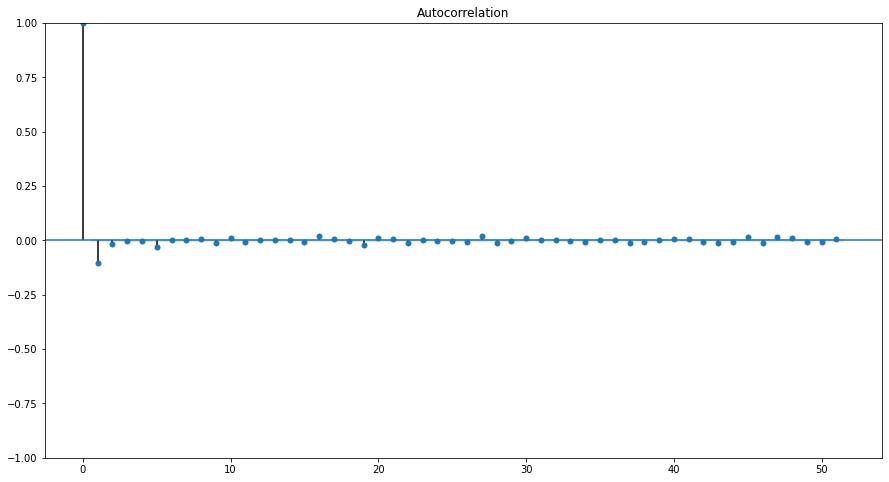

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
_ = plot_acf(combined_data['adjusted_close_log_diff'])

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


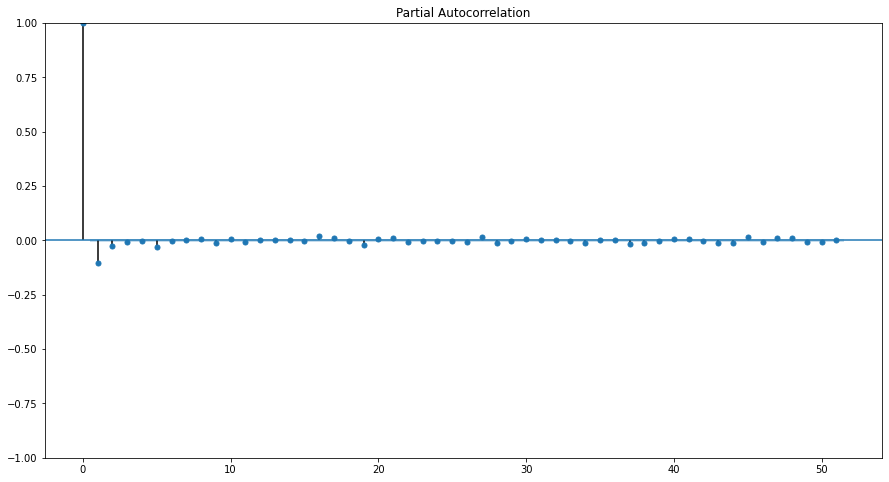

In [ ]:
_ = plot_pacf(combined_data['adjusted_close_log_diff'])

Looks like it is indeed an AR(1) process.

We will fit a simple AutoRegressive model to the stock data and predict the next day's price.

Finally, we will rank the stocks in descending order based on the difference between the predicted price (T0 + 1) and the most recent price in the data (T0).

This model will serve as a baseline for a more sophisticated model.

<BarContainer object of 27 artists>

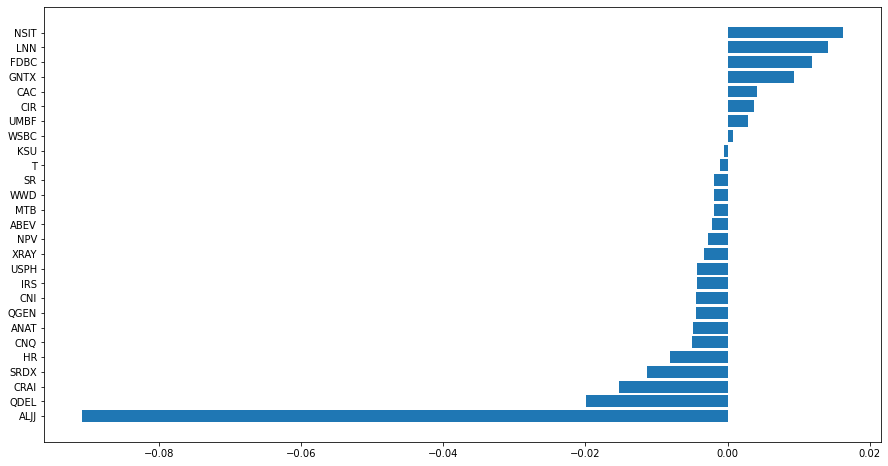

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict

diffs = OrderedDict()
for symbol in combined_data.symbol.unique():
  ts_data = combined_data[combined_data.symbol == symbol][['timestamp_as_dt', 'adjusted_close_log']]
  ts_data.set_index('timestamp_as_dt', inplace = True)

  res = AutoReg(ts_data, [1]).fit()
  predicted = res.predict(end = ts_data.shape[0])
  diffs[symbol] = predicted[ts_data.shape[0] - 1] - predicted[ts_data.shape[0]]

diffs = OrderedDict(sorted(diffs.items(), key=lambda t: t[1]))

lists = diffs.items()
lists 
x, y = zip(*lists)

plt.barh(x, y)

## Evaluate naîve model

# Section 4: Improve on the naîve baseline model.

This section will hope to improve on the model above by incorporating exogenous variables.